# Notes on Computing the Rollout Acquisition Function
## Considerations
- Incorporate control variates for variance reduction on rollout acquisition function
- Give further consideration for the construction of arbitrary kernels and maintaining which hyperparameters belong to which kernels. I think we can borrow from the `Multi-Fidelity Bayesian Optimization` repository. I need to treat scaling of kernels as creating a kernel object with a single hyperparameter and multiply this `ScaleKernel` against the other kernel.

## What I'm Doing
- [x] Remove conditioning fantasized surrogate on gradient samples
- [ ] Write a method for estimating the acquisition function using forward mode differentation

We have a few ways of computing surrogate perturbations. One relies on computing perturbations of our `RBFsurrogate` with the data and spatial perturbations performed jointly. One relies on `FantasySurrogate` which leverages smart indexing to compute perturbations of data and spatial locations independently. The final one is wrt to `SmartFantasyRBFsurrogate` which does them idenpendtly as well.

## Possible Issues
- [ ] Low discrepancy seqeuence possibly
- [ ] Adjoint differentiation seems to be off. I think we need to check our hessians and return 0 if the det is too small.
- [ ] Use the Forward and Adjoint API to rollout trajectories at some fixed point to identify why they are different for the stochastic case.

In [51]:
using Distributions
using LinearAlgebra
using Plots
using Roots

All the necessary imports for our computations of interest

In [52]:
include("../rollout_bayesian_optimization.jl")

deterministic_solve (generic function with 1 method)

## Basic Setup

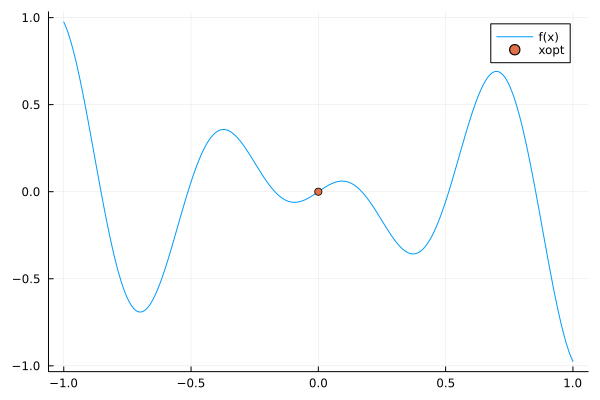

In [8]:
# Visualize 1D test function
testfn = TestLinearCosine1D(1., 9.2, lb=-1, ub=1.)
# testfn = TestConstant(lbs=[0.], ubs=[1.])
# testfn = TestQuadratic1D()
tplot(testfn)

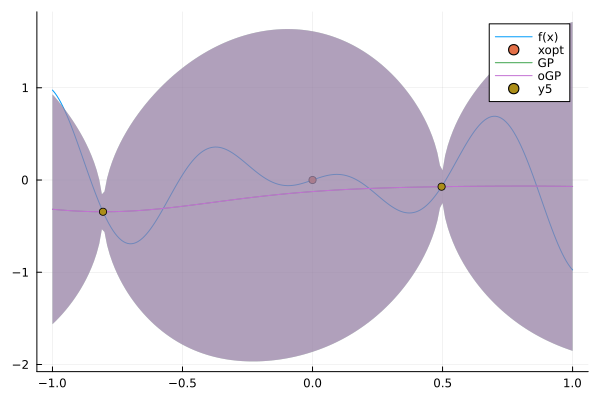

In [14]:
MC_SAMPLES = 10
NUMBER_OF_STARTS = 8
HORIZON = 1
USE_LDS = false
INITIAL_SAMPLES = 2

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
θinit = [0.0]
ψ = Periodic([1., 3.])
# ψ = kernel_scale(Periodic, [5., .25, .25])

lbs, ubs = get_bounds(testfn)
midpoint = (ubs + lbs) / 2
domain = dense_1D_discretization(lb=first(lbs), ub=first(ubs), stepsize=.01)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    start=midpoint,
    horizon=HORIZON,
    mc_iterations=MC_SAMPLES,
    use_low_discrepancy_sequence=USE_LDS,
    spatial_lowerbounds=lbs,
    spatial_upperbounds=ubs,
    hypers=θinit
)
es = ExperimentSetup(number_of_starts=NUMBER_OF_STARTS, tp=tp)

Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
# Xinit = [.15;; .85;;]
yinit = testfn(Xinit)
sur = Surrogate(ψ, Xinit, yinit, decision_rule=EI(), σn2=σn2);
osur = fit_surrogate(ψ, Xinit, yinit, σn2=σn2);

tplot(testfn)
plot!(domain, [sur([x], θinit).μ for x in domain], ribbons=2sqrt.([sur([x], θinit).σ for x in domain]), label="GP")
plot!(domain, [osur([x]).μ for x in domain], ribbons=2sqrt.([osur([x]).σ for x in domain]), label="oGP")
scatter!(sur.X', sur.y)

## Visualizing Base Policy Solves along a Trajectory

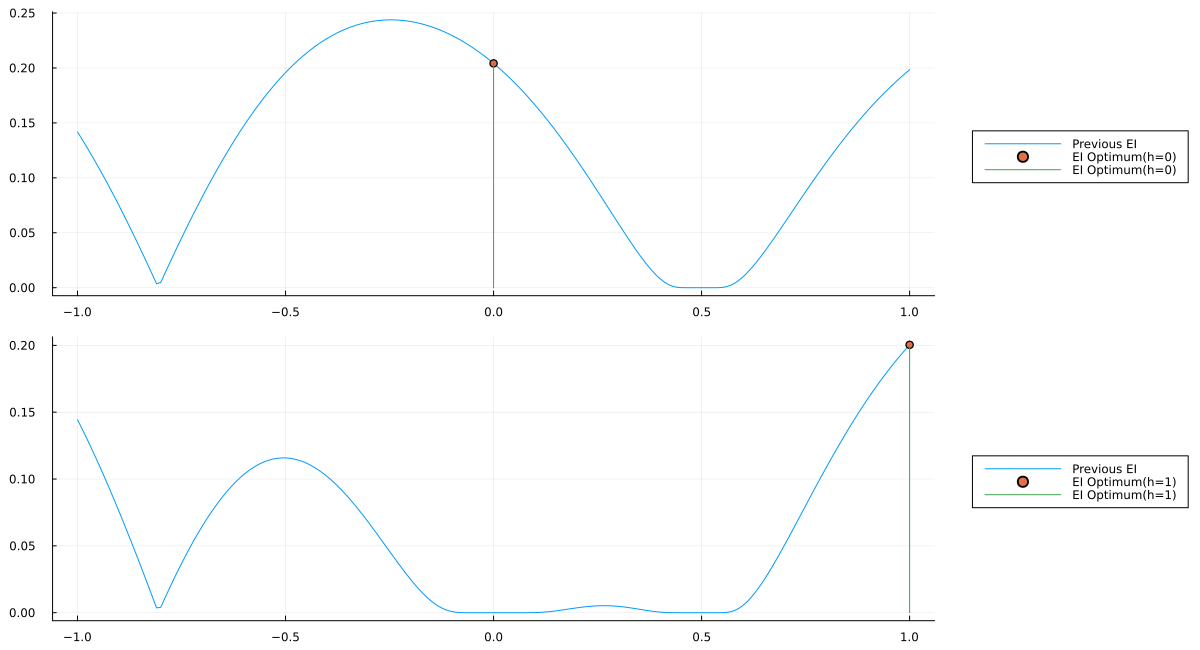

In [15]:
IS_DETERMINISTIC = true
# Construct the inner policy
decision_rule = EI()
lbs, ubs = get_spatial_bounds(tp)

# Construct GP
sur = Surrogate(ψ, Xinit, yinit, decision_rule=decision_rule, σn2=σn2)

# Construct trajectory
AT = AdjointTrajectory(
    base_surrogate=sur,
    start=get_starting_point(tp),
    hypers=get_hyperparameters(tp),
    horizon=get_horizon(tp)
)
stochastic_sampler = StochasticObservable(
    surrogate=get_fantasy_surrogate(AT),
    stdnormal=get_samples_rnstream(tp, sample_index=1),
    max_invocations=get_horizon(tp) + 1
)
deterministic_sampler = DeterministicObservable(
    func=testfn.f,
    gradient=testfn.∇f,
    max_invocations=get_horizon(tp) + 1
)
attach_observable!(AT, IS_DETERMINISTIC ? deterministic_sampler : stochastic_sampler)
# Adjoint Rollout
rollout!(
    AT,
    lowerbounds=lbs,
    upperbounds=ubs,
    xstarts=get_starts(es),
    get_observation=get_observable(AT)
)

FT = ForwardTrajectory(
    base_surrogate=osur,
    start=get_starting_point(tp),
    horizon=get_horizon(tp)
)
stochastic_sampler = StochasticObservable(
    surrogate=get_fantasy_surrogate(FT),
    stdnormal=get_samples_rnstream(tp, sample_index=1),
    max_invocations=get_horizon(tp) + 1
)
deterministic_sampler = DeterministicObservable(
    func=testfn.f,
    gradient=testfn.∇f,
    max_invocations=get_horizon(tp) + 1
)
attach_observable!(FT, IS_DETERMINISTIC ? deterministic_sampler : stochastic_sampler)
rollout!(
    FT,
    lowerbounds=lbs,
    upperbounds=ubs,
    xstarts=get_starts(es),
    get_observation=get_observable(FT)
)

all_plots = []

for upto_index in 0:HORIZON
    EIx = zeros(length(domain))
    for (i, xx) in enumerate(domain)
        EIx[i] = eval(AT.fs([xx], θinit, fantasy_index=upto_index-1))
    end
    p = plot(domain, EIx, label="Previous EI")
    target_location = first(AT.fs.X[:, INITIAL_SAMPLES + upto_index + 1])
    
    scatter!(
        [target_location],
        [eval(AT.fs([target_location], θinit, fantasy_index=upto_index-1))],
        label="EI Optimum(h=$upto_index)"
    )
    
    plot!(
        [target_location, target_location],
        [0., eval(AT.fs([target_location], θinit, fantasy_index=upto_index-1))],
        label="EI Optimum(h=$upto_index)"
    )
    push!(all_plots, p)
end

plot(all_plots..., layout=(length(all_plots), 1), size=(1200, 325 * (HORIZON + 1)), legend=:outerright)

In [16]:
etos = []
old_etos = []
resolutions = zeros(MC_SAMPLES)
gresolutions = zeros(testfn.dim, MC_SAMPLES)
output = nothing

for (index, xx) in enumerate(domain)
    print("|")
    # Adjoint mode
    if IS_DETERMINISTIC
        set_starting_point!(tp, [xx])
        eto = deterministic_simulate_trajectory(
            sur,
            tp,
            inner_solve_xstarts=get_starts(es),
            func=testfn.f,
            grad=testfn.∇f
        )
        set_starting_point!(tp, [xx])
        eto2 = d_simulate_trajectory(
            osur,
            tp,
            xstarts=get_starts(es),
            func=testfn.f,
            grad=testfn.∇f
        )
        push!(etos, eto)
        push!(old_etos, eto2)
    else
        set_starting_point!(tp, [xx])
        eto = simulate_adjoint_trajectory(
            sur,
            tp,
            inner_solve_xstarts=get_starts(es),
            resolutions=get_container(es, symbol=:f),
            spatial_gradients_container=get_container(es, symbol=:grad_f),
            hyperparameter_gradients_container=get_container(es, symbol=:grad_hypers)
        )
        set_starting_point!(tp, [xx])
        # eto2 = simulate_forward_trajectory(osur, tp, get_starts(es), resolutions=resolutions, gradient_resolutions=gresolutions)
        eto2 = simulate_trajectory(osur, tp, xstarts=get_starts(es), resolutions=resolutions, gradient_resolutions=gresolutions)
        push!(etos, eto)
        push!(old_etos, eto2)
    end
    
end

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

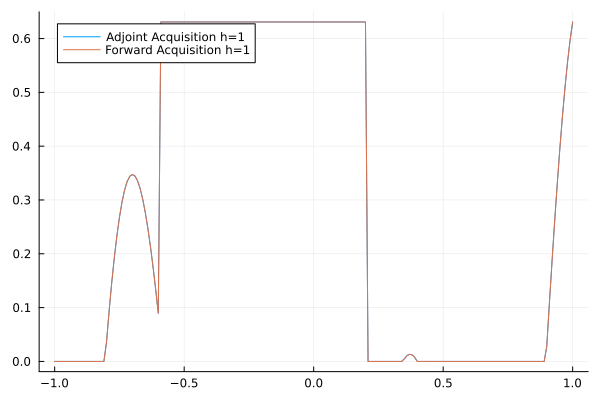

In [17]:
plot(
    domain,
    [mean(eto) for eto in etos],
    # ribbons=[std(eto) / sqrt(MC_SAMPLES) for eto in etos],
    label="Adjoint Acquisition h=$(get_horizon(tp))"
)
if IS_DETERMINISTIC
    plot!(
        domain,
        [mean(oo) for oo in old_etos],
        label="Forward Acquisition h=$(get_horizon(tp))"
    )
else
    plot!(
        domain,
        [oo[1] for oo in old_etos],
        label="Forward Acquisition h=$(get_horizon(tp))"
    )
end

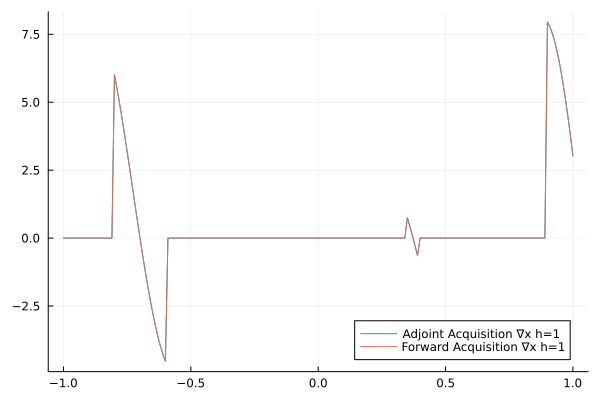

In [18]:
plot(
    domain,
    [(first ∘ gradient)(eto) for eto in etos],
    # ribbons=[(first ∘ std_gradient)(eto) / sqrt(MC_SAMPLES) for eto in etos],
    label="Adjoint Acquisition ∇x h=$(get_horizon(tp))"
)
# plot()
if IS_DETERMINISTIC
    plot!(
        domain,
        [(first ∘ gradient)(oo) for oo in old_etos],
        label="Forward Acquisition ∇x h=$(get_horizon(tp))"
    )
else
    plot!(
        domain,
        [oo[2][1] for oo in old_etos],
        label="Forward Acquisition ∇x h=$(get_horizon(tp))"
    )
end

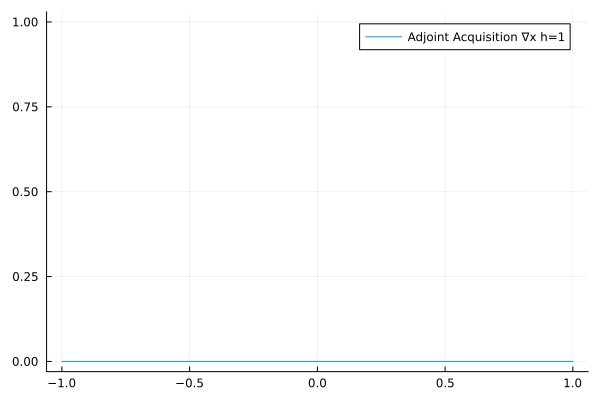

In [54]:
plot(
    domain,
    [first(gradient(eto, wrt_hypers=true)) for eto in etos],
    # ribbons=[(first ∘ std_gradient)(eto) / sqrt(MC_SAMPLES) for eto in etos],
    label="Adjoint Acquisition ∇x h=$(get_horizon(tp))"
)

In [68]:
include("../rollout_bayesian_optimization.jl")

LoadError: LoadError: invalid redefinition of constant Main.PreallocatedSurrogate
in expression starting at /Users/jamosa/Documents/academia/cornell-university/research/projects/kernel-numerics-refactor-revamp/radial_basis_surrogates.jl:38
in expression starting at /Users/jamosa/Documents/academia/cornell-university/research/projects/kernel-numerics-refactor-revamp/rollout_bayesian_optimization.jl:19

In [58]:
sur = Surrogate(ψ, Xinit, yinit, decision_rule=EI(), σn2=σn2);
psur = PreallocatedSurrogate(ψ, Xinit, yinit, decision_rule=EI(), σn2=σn2, capacity=100)

PreallocatedSurrogate{RadialBasisFunction, DecisionRule{var"#ei#2719"{Float64}}}(RadialBasisFunction, [-0.8057314080081006 0.4963043288098694 … 0.0 0.0], [1.000001 0.14730186027989045 … 0.0 0.0; 0.14730186027989045 1.000001 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [1.000000499999875 0.0 … 0.0 0.0; 0.14730178662901555 0.9890921006943185 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-0.34410572284736796, -0.07239435765017588], [-0.3408369874760872, -0.022188413154341353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1.0e-6, DecisionRule{EI}, 2, 100)

In [67]:
psur.X[:, 1:4]

1×4 Matrix{Float64}:
 -0.805731  0.496304  0.0  0.0